Key Highlights

1.End-to-end ML pipeline (Data → Model → SQL → Dashboard)

2.Time-series forecasting using lag features

3.Business-aware feature engineering

4.Production-ready SQL Server integration

5.Tableau-ready outputs for live pricing dashboards

In [33]:
# Importing Libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import pyodbc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Connecting to SQL server
print("Connecting SQL Server...")
server = 'localhost'
database = 'projects'

print("")

conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    f'SERVER={server};'
    f'DATABASE={database};'
    'Trusted_Connection=yes;'
)
print("Server Connected Successfully")

Connecting SQL Server...

Server Connected Successfully


In [ ]:
# Getting Train Data from SQL Server
df = pd.read_sql("SELECT * FROM Train", conn)

df['timestamp'] = pd.to_datetime(df['timestamp'])
df.drop_duplicates(inplace=True)

C:\Users\jagat\AppData\Local\Temp\ipykernel_3772\1173330065.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM Train", conn)


In [4]:
# Fill missing values
df.fillna({
    'demand_index': df['demand_index'].median(),
    'inventory_level': df['inventory_level'].median(),
    'competitor_price': df['competitor_price'].median()
}, inplace=True)

In [5]:
# Time features
df['month'] = df['timestamp'].dt.month
df['day_of_year'] = df['timestamp'].dt.dayofyear
df['is_weekend'] = (df['timestamp'].dt.weekday >= 5).astype(int)

In [6]:
# Sort for lags
df.sort_values(['product_id', 'timestamp'], inplace=True)

In [7]:
# Lag features
df['price_lag_1'] = df.groupby('product_id')['current_price'].shift(1)
df['price_lag_7'] = df.groupby('product_id')['current_price'].shift(7)
df.fillna(method='bfill', inplace=True)

C:\Users\jagat\AppData\Local\Temp\ipykernel_3772\2786099926.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [8]:
# Business logic features
df['price_gap'] = df['current_price'] - df['competitor_price']
df['inventory_pressure'] = df['demand_index'] / (df['inventory_level'] + 1)

In [9]:
# One-hot encode season
df = pd.get_dummies(df, columns=['season'], drop_first=True)

In [10]:
# Target = next-period price
df['target_price'] = df.groupby('product_id')['current_price'].shift(-1)
df.dropna(inplace=True)

In [ ]:
# Features for Train the Model
feature_cols = [
    'base_price', 'demand_index', 'inventory_level',
    'competitor_price', 'price_gap', 'inventory_pressure',
    'price_lag_1', 'price_lag_7',
    'month', 'day_of_year', 'is_weekend'
] + [c for c in df.columns if c.startswith('season_')]
X = df[feature_cols]
y = df['target_price']
split_date = df['timestamp'].quantile(0.8)
X_train = X[df['timestamp'] <= split_date]
X_test  = X[df['timestamp'] > split_date]
y_train = y[df['timestamp'] <= split_date]
y_test  = y[df['timestamp'] > split_date]

In [ ]:
# Model Creating and Fit the Data (Light Gradient Boosting Machine)
model = lgb.LGBMRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1954
[LightGBM] [Info] Number of data points in the train set: 644736, number of used features: 14
[LightGBM] [Info] Start training from score 2435.172053


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,6
,learning_rate,0.05
,n_estimators,400
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [13]:
# Evaluate the Model Performance
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100

print("\nMODEL PERFORMANCE")
print("R²:", round(r2, 3))
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("MAPE:", round(mape, 2))
print("Accuracy:", round(100 - mape, 2), "%")



MODEL PERFORMANCE
R²: 0.99
MAE: 69.02
RMSE: 86.46
MAPE: 3.12
Accuracy: 96.88 %


Test

In [ ]:
# Getting the Test Dataset from the SQL server
test_raw = pd.read_sql("SELECT * FROM Test", conn)

test_raw['timestamp'] = pd.to_datetime(test_raw['timestamp'])
test_raw.drop_duplicates(inplace=True)

C:\Users\jagat\AppData\Local\Temp\ipykernel_3772\1160661954.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  test_raw = pd.read_sql("SELECT * FROM Test", conn)


In [15]:
# Copy dataset
test_feat = test_raw.copy()

# Handle missing values
test_feat.fillna({
    'demand_index': df['demand_index'].median(),
    'inventory_level': df['inventory_level'].median(),
    'competitor_price': df['competitor_price'].median()
}, inplace=True)

# Extract Month,days,Weekend
test_feat['month'] = test_feat['timestamp'].dt.month
test_feat['day_of_year'] = test_feat['timestamp'].dt.dayofyear
test_feat['is_weekend'] = (test_feat['timestamp'].dt.weekday >= 5).astype(int)

# Sort data correctly
test_feat.sort_values(['product_id', 'timestamp'], inplace=True)

In [16]:
# Take last 7 days of train per product
history = (
    df[['product_id', 'timestamp', 'current_price']]
    .groupby('product_id')
    .tail(7)
)

# Combine historical data with future (test) data
combined = pd.concat([history, test_feat], ignore_index=True)
combined.sort_values(['product_id', 'timestamp'], inplace=True)

# Create lag features across the combined timeline
combined['price_lag_1'] = combined.groupby('product_id')['current_price'].shift(1)
combined['price_lag_7'] = combined.groupby('product_id')['current_price'].shift(7)

In [17]:
# Filter ONLY test rows (SAFE KEYS)
test_keys = test_feat[['product_id', 'timestamp']]
test_feat = combined.merge(
    test_keys,
    on=['product_id', 'timestamp'],
    how='inner'
)

# Fill missing lag values safely
test_feat[['price_lag_1', 'price_lag_7']] = (
    test_feat[['price_lag_1', 'price_lag_7']]
    .fillna(method='bfill')
)

# Price gap (competitive positioning)
test_feat['price_gap'] = test_feat['current_price'] - test_feat['competitor_price']

# Inventory pressure (supply-demand signal)
test_feat['inventory_pressure'] = test_feat['demand_index'] / (test_feat['inventory_level'] + 1)

# Encode seasonal information (model compatibility)
test_feat = pd.get_dummies(test_feat, columns=['season'], drop_first=True)

C:\Users\jagat\AppData\Local\Temp\ipykernel_3772\139306765.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_feat[['price_lag_1', 'price_lag_7']]


In [18]:
# Align with training features
X_test_final = test_feat.reindex(columns=X.columns, fill_value=0)

In [19]:
# Predict
predictions = model.predict(X_test_final)

pred_df = test_feat[['product_id', 'timestamp']].copy()
pred_df['predicted_price'] = predictions

In [20]:
# Merge back into raw test data
test_final = test_raw.merge(
    pred_df,
    on=['product_id', 'timestamp'],
    how='left'
)

In [21]:
# Final Output 
final_output = test_final[['product_id', 'timestamp', 'predicted_price']] \
    .sort_values(['product_id', 'timestamp'])

print(final_output.head(5))


     product_id           timestamp  predicted_price
113        3001 2025-01-01 00:00:00      2118.479768
261        3001 2025-01-01 01:00:00      2040.784936
262        3001 2025-01-01 01:00:00      2040.784936
263        3001 2025-01-01 01:00:00      1696.353644
264        3001 2025-01-01 01:00:00      1696.353644


In [22]:
# Ensure date column is datetime
test_final['timestamp'] = pd.to_datetime(test_final['timestamp'])

# Filter January data
jan_df = test_final[test_final['timestamp'].dt.month == 1]
feb_df = test_final[test_final['timestamp'].dt.month == 2]
mar_df = test_final[test_final['timestamp'].dt.month == 3]

In [23]:
# Convert product_ID to Product_Key
product_ids = [3001,3002,3003,3004,3005,3006,3007,3008,3009,3010,
            3011,3012,3013,3014,3015,3016,3017,3018,3019,3020,
            3021,3022,3023]

jan_df = jan_df[jan_df['product_id'].isin(product_ids)]
feb_df = feb_df[feb_df['product_id'].isin(product_ids)]
mar_df = mar_df[mar_df['product_id'].isin(product_ids)]


In [24]:
# Group the price based on the Product_id and sum the predicted_price
product_sum_jan = (
    jan_df
    .groupby('product_id')[['base_price', 'predicted_price']]
    .sum()
    .reset_index()
)
product_sum_feb = (
    feb_df
    .groupby('product_id')[['base_price', 'predicted_price']]
    .sum()
    .reset_index()
)
product_sum_mar = (
    mar_df
    .groupby('product_id')[['base_price', 'predicted_price']]
    .sum()
    .reset_index()
)

In [25]:
# Sort to keep consistent order
product_sum_jan = product_sum_jan.sort_values('product_id').reset_index(drop=True)
product_sum_feb = product_sum_feb.sort_values('product_id').reset_index(drop=True)
product_sum_mar = product_sum_mar.sort_values('product_id').reset_index(drop=True)

# Create P1, P2, P3...
product_sum_jan['product_label'] = ['P' + str(i+1) for i in range(len(product_sum_jan))]
product_sum_feb['product_label'] = ['P' + str(i+1) for i in range(len(product_sum_feb))]
product_sum_mar['product_label'] = ['P' + str(i+1) for i in range(len(product_sum_mar))]


In [26]:
test_final.head()

,timestamp,product_id,product_name,base_price,demand_index,units_sold_last_hour,inventory_level,competitor_price,season,is_weekend,hour,day_of_year,column13,column14,column15,predicted_price
0,2025-01-01,3013,EcoBrew Drip Coffee Maker,1141,29,2,645,1246.020020,0,0,0,1,None,None,None,2146.065136
1,2025-01-01,3013,EcoBrew Drip Coffee Maker,1141,29,2,645,1246.020020,0,0,0,1,None,None,None,2146.065136
2,2025-01-01,3013,EcoBrew Drip Coffee Maker,1141,29,2,645,1246.020020,0,0,0,1,None,None,None,2216.874514
3,2025-01-01,3013,EcoBrew Drip Coffee Maker,1141,29,2,645,1246.020020,0,0,0,1,None,None,None,2216.874514
4,2025-01-01,3023,TrailMax 45L Travel Backpack,1709,60,5,1087,1711.540039,0,0,0,1,None,None,None,1123.268953


In [27]:
# Train predictions
train_preds = model.predict(X_train)

train_r2 = r2_score(y_train, train_preds)
train_mape = np.mean(np.abs((y_train - train_preds) / y_train)) * 100

print("OVERFITTING CHECK")
print(f"Train R²  : {train_r2:.4f}")
print(f"Test  R²  : {r2:.4f}")
print(f"Train MAPE: {train_mape:.2f}%")
print(f"Test  MAPE: {mape:.2f}%")


OVERFITTING CHECK
Train R²  : 0.9906
Test  R²  : 0.9904
Train MAPE: 3.21%
Test  MAPE: 3.12%


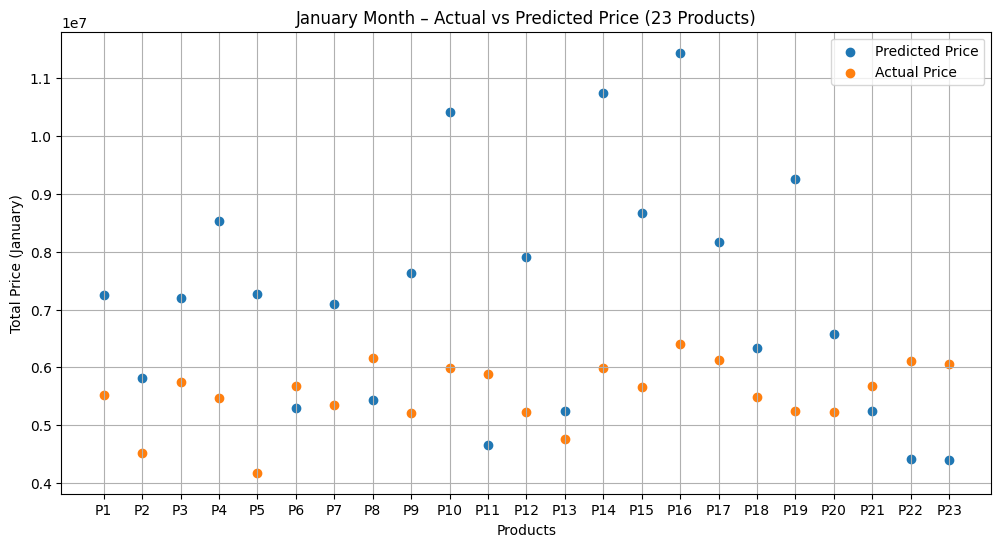

In [28]:
# Plot the Jan month predicted Price
x = range(len(product_sum_jan))

plt.figure(figsize=(12,6))

plt.scatter(
    x,
    product_sum_jan['predicted_price'],
    label='Predicted Price'
)

plt.scatter(
    x,
    product_sum_jan['base_price'],
    label='Actual Price'
)

plt.xlabel('Products')
plt.ylabel('Total Price (January)')
plt.title('January Month – Actual vs Predicted Price (23 Products)')
plt.legend()
plt.grid(True)

# Replace x-axis values with P1, P2, P3...
plt.xticks(x, product_sum_jan['product_label'])

plt.show()


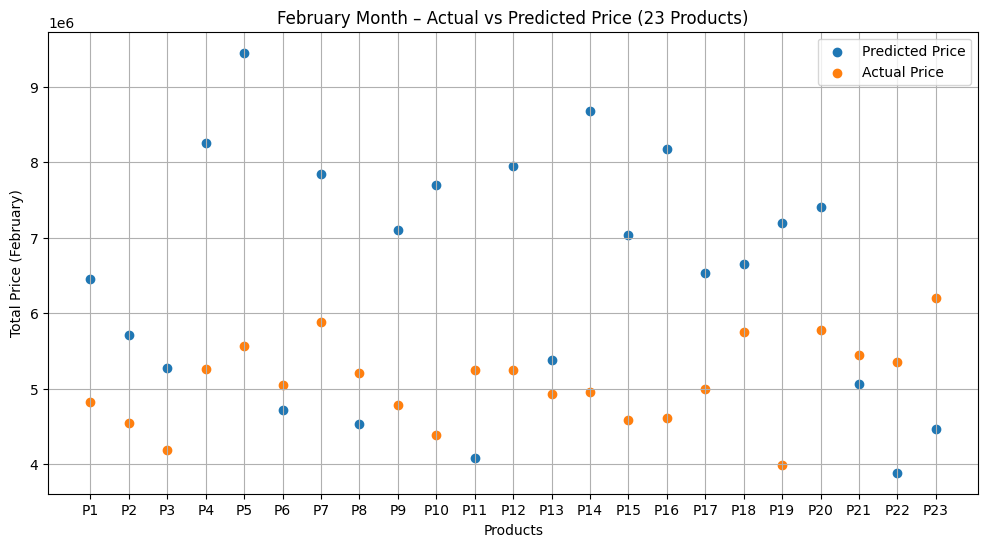

In [29]:
# Plot the Feb month predicted Price

x = range(len(product_sum_feb))  # numeric positions

plt.figure(figsize=(12,6))

plt.scatter(
    x,
    product_sum_feb['predicted_price'],
    label='Predicted Price'
)

plt.scatter(
    x,
    product_sum_feb['base_price'],
    label='Actual Price'
)

plt.xlabel('Products')
plt.ylabel('Total Price (February)')
plt.title('February Month – Actual vs Predicted Price (23 Products)')
plt.legend()
plt.grid(True)

# Replace x-axis values with P1, P2, P3...
plt.xticks(x, product_sum_jan['product_label'])

plt.show()


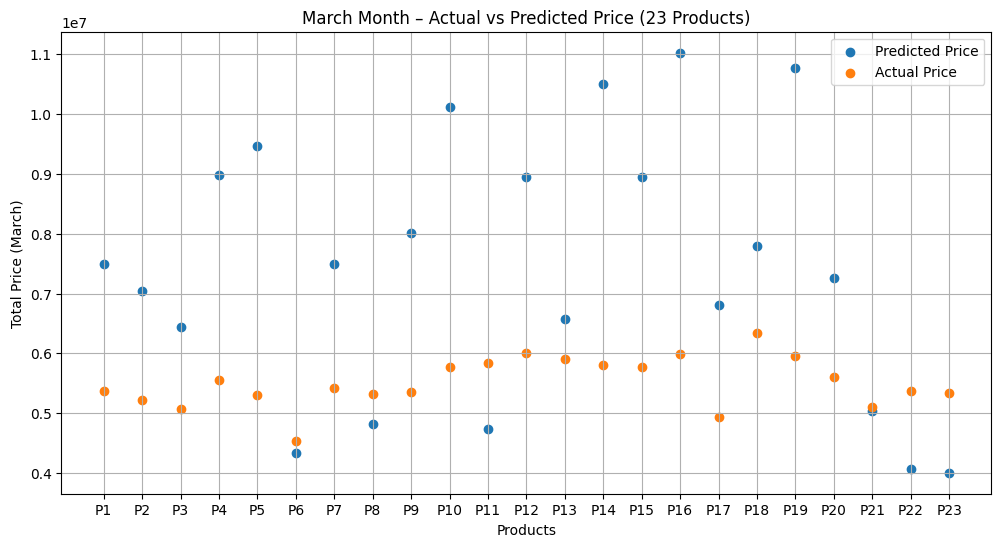

In [30]:
# Plot the Mar month predicted Price

x = range(len(product_sum_mar))  # numeric positions

plt.figure(figsize=(12,6))

plt.scatter(
    x,
    product_sum_mar['predicted_price'],
    label='Predicted Price'
)

plt.scatter(
    x,
    product_sum_mar['base_price'],
    label='Actual Price'
)

plt.xlabel('Products')
plt.ylabel('Total Price (March)')
plt.title('March Month – Actual vs Predicted Price (23 Products)')
plt.legend()
plt.grid(True)

# Replace x-axis values with P1, P2, P3...
plt.xticks(x, product_sum_mar['product_label'])

plt.show()


In [31]:
import pyodbc

conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=localhost;'
    'DATABASE=projects;'
    'Trusted_Connection=yes;'
)


In [32]:
cursor = conn.cursor()

#clear old predictions
cursor.execute("TRUNCATE TABLE Price_Predictions")
conn.commit()

insert_query = """
INSERT INTO Price_Predictions (product_id, timestamp, predicted_price)
VALUES (?, ?, ?)
"""

for _, row in final_output.iterrows():
    cursor.execute(
        insert_query,
        int(row['product_id']),
        row['timestamp'],
        float(row['predicted_price'])
    )

conn.commit()
cursor.close()

print("Predictions written to SQL Server successfully")


Predictions written to SQL Server successfully


Dynamic Pricing Project – Summary

1. Built a dynamic pricing prediction model to forecast future product prices

2. Used historical pricing, demand, inventory, and competitor data

3. Performed data cleaning and feature engineering

4. Created time-based features (month, weekend, day of year)

5. Added lag features (previous day & previous week prices)

6. Engineered business features like price gap and inventory pressure

7. Trained a LightGBM regression model for price prediction

8. Used time-based train-test split to avoid data leakage

9. Evaluated model using R², MAE, RMSE, and MAPE

10. Generated future price predictions for test data

11. Stored predictions in SQL Server for production use

12. Visualized results and trends using Tableau and Python charts